<a href="https://colab.research.google.com/github/aalr007/VisionComputacional/blob/main/SuperpixelesEquipo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> ***Visión computacional para imágenes y video*** </center>
## <center> ***Proyecto Final Equipo 6*** </center>
## <center> ***SuperPixeles*** </center>
### Profesor: Gilberto Ochoa Ruiz
### Alumnos:
* Alberto Nieves Cisneros            A01793829
* Aurelio Antonio Lozano Rábago      A01081266
* Héctor Manuel González Villareal   A00178679
* Jessica Lechuga Ramos              A01793512
* Luis Alfredo Negron Naldos         A01793865

#### <p style='text-align: right;'> 16 de Marzo del 2023 </p>

In [4]:
# import the necessary packages
import argparse
import matplotlib.pyplot as plt

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import cv2

from cv2 import ximgproc
from google.colab.patches import cv2_imshow
import numpy as np

# K-Means
Since superpixels is based on k-means, a review of this method will be given.

In [5]:
img = cv2.imread("sample_data/image.jpg")

In [6]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = img.reshape((-1,3))
 # Convert to float type
pixel_vals = np.float32(pixel_vals)

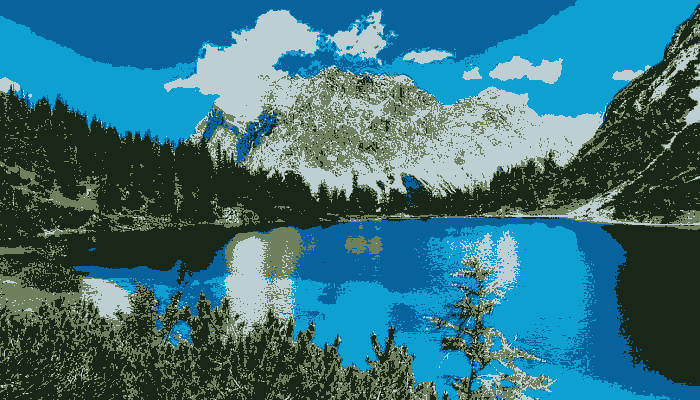

In [7]:
#the below line of code defines the criteria for the algorithm to stop running,
#cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
#cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering with number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 5
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((img.shape))
 
cv2_imshow(segmented_image)

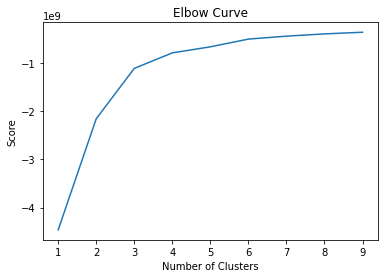

In [8]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i,n_init="auto") for i in Nc]
kmeans 
score = [kmeans[i].fit(pixel_vals).score(pixel_vals) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Superpixels with Skimage library

As we know, superpixels (2003) are understood as a grouping of a determined number of pixels with similar characteristics and it is the main axis of the SLIC algorithm.
The SLIC superpixel algorithm by its acronym called simple linear interactive clustering or simple linear interactive clustering, is an algorithm proposed by Achanta in 2012, it is simple and its advantages are:
* Fast and efficient in memory, in contrast to the algorithms that were proposed at that time.
* Improved segmentation performance
* Ease of extension to the generation of supervoxels (3D images)

The advantages correspond to the computational performance, this is due to the fact that its algorithmic complexity is N, SLIC is a modification of the k-means algorithm, that is why an introduction of it was given, its main differences with this one are:
* The number of distance calculations in the optimization is drastically reduced by limiting the search space to a region proportional to the size of the superpixels. This reduces complexity by being linear in the number of pixels.
* A weighted distance measure combines color and spatial proximity while providing control over the size and compactness of superpixels.

In [9]:
# load the image and convert it to a floating point data type
image = img_as_float(io.imread("sample_data/image.jpg"))


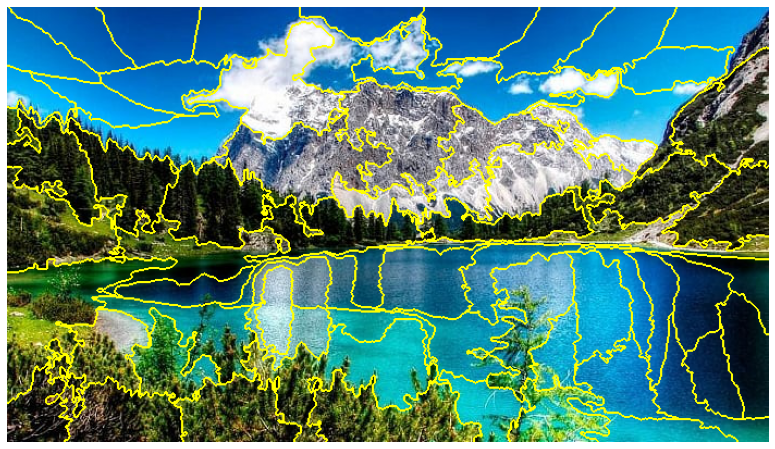

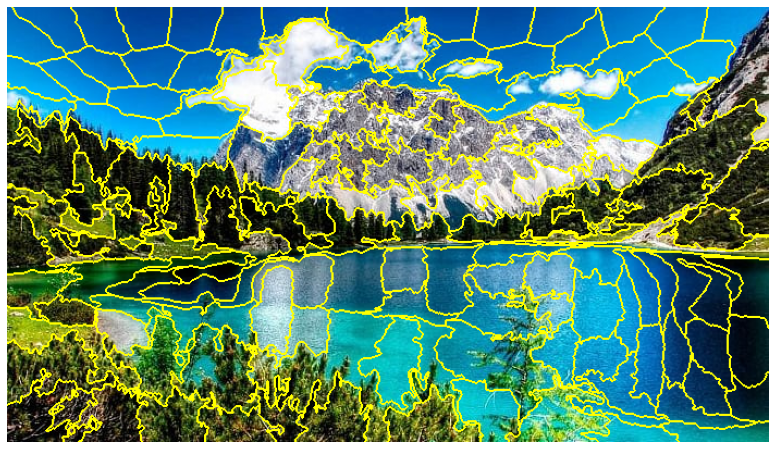

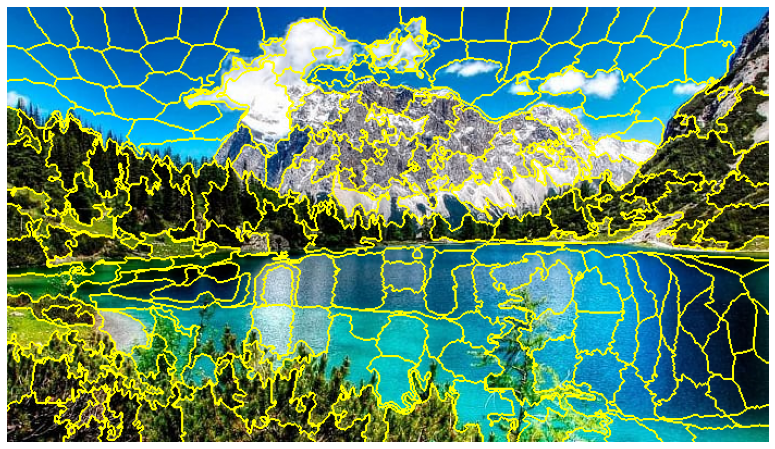

<Figure size 7200x21600 with 0 Axes>

In [10]:
# loop over the number of segments
for numSegments in (100, 200, 300):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(image, n_segments = numSegments, sigma = 1)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments), figsize=(16, 8))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(image, segments))
	plt.axis("off")
# show the plots
plt.figure(figsize=(100,300))
plt.show()

We can observe that by varying the size of the region in an image, the level of detail that can be lost or preserved greatly influences, since the larger the region, the grouping of pixels with common characteristics can be made, leaving aside the bias of grouping of inappropriate pixels without However, a balance needs to be maintained to make the computational performance worthwhile.

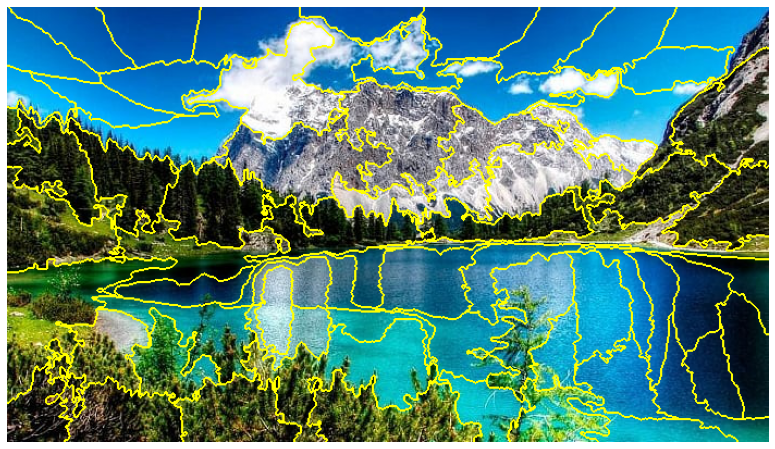

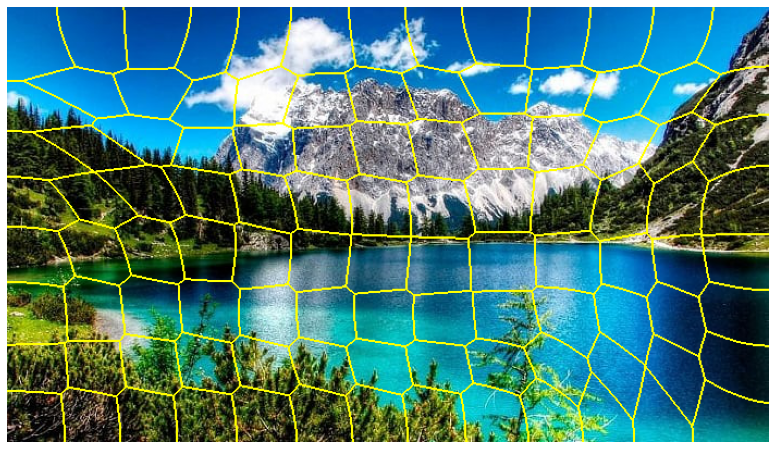

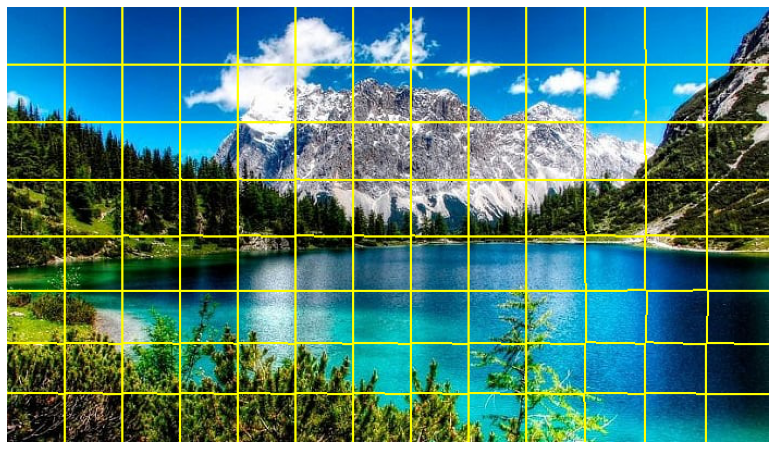

<Figure size 7200x21600 with 0 Axes>

In [11]:
# loop over the sigma
for sigma in (1, 64, 255):
	numSegments = 100
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(image, n_segments = numSegments, sigma = sigma)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d sigma" % (sigma), figsize=(16, 8))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(image, segments))
	plt.axis("off")
# show the plots
plt.figure(figsize=(100,300))
plt.show()

By varying sigma it is possible to see how compact the pixels are left within a region (superpixel), it is shown that at less sigma the regions can adhere closely to the borders of an image, having the advantage of better capturing the irregular shapes of an image.

#Superpixels with Opencv library

In [12]:
import cv2
from cv2 import ximgproc
from google.colab.patches import cv2_imshow
import numpy as np

Linear Spectral Clustering

Class implementing the LSC (Linear Spectral Clustering) superpixels.

Parameters
* image	Image to segment
* region_size	Chooses an average superpixel size measured in pixels
* ratio	Chooses the enforcement of superpixel compactness factor of superpixel

The function initializes a SuperpixelLSC object for the input image. It sets the parameters of superpixel algorithm, which are: region_size and ruler. It preallocate some buffers for future computing iterations over the given image. An example of LSC is ilustrated in the following picture. For enanched results it is recommended for color images to preprocess image with little gaussian blur with a small 3 x 3 kernel and additional conversion into CieLAB color space.

In [13]:
img = cv2.imread("sample_data/image.jpg")

In [14]:
print(img.shape)

(400, 700, 3)


In [15]:
region_size = 50  #con esto se calcula el numero de superpixeles: tamaño de la imagen / (region size^2) --> en este caso la imagen es de 700*400/(50*50) = 112 superpixeles
ratio = .5  #con este parametro se ajusta la forma del superpixel, a mas pequeño, mas se ajustara a la forma adecuada (tipo sobre entrenamiento), radio de 0.5, los pixeles se ven muy cuadrados

In [16]:
iLSC = cv2.ximgproc.createSuperpixelLSC(img, region_size, ratio)
iLSC.iterate(10)


color_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
color_img[:] = (0, 0, 255)


mask_slsc = iLSC.getLabelContourMask() #Get Mask, superpixel edge Mask==1
label_slsc = iLSC.getLabels() #Get superpixel labels
number_slsc = iLSC.getNumberOfSuperpixels() #Get the number of superpixels
mask_inv_slsc = cv2. bitwise_not(mask_slsc) 
img_slsc = cv2.bitwise_and(img,img,mask = mask_inv_slsc) #Draw superpixel boundaries on the original image
img2 = cv2.bitwise_and(color_img, color_img, mask=mask_slsc) 
resultslsc = cv2.add(img_slsc, img2)

In [17]:
print("labels", label_slsc)
print("Number of pixels", number_slsc)


labels [[  0   0   0 ... 104 104 104]
 [  0   0   0 ... 104 104 104]
 [  0   0   0 ... 104 104 104]
 ...
 [  7   7   7 ... 111 111 111]
 [  7   7   7 ... 111 111 111]
 [  7   7   7 ... 111 111 111]]
Number of pixels 112


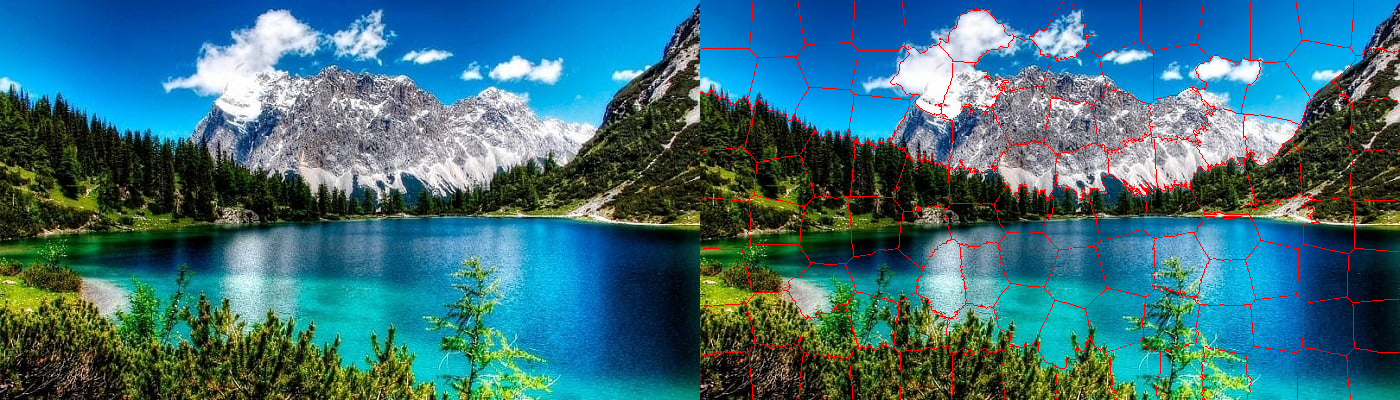

In [18]:
h_img = cv2.hconcat([img, resultslsc])

cv2_imshow(h_img)

Superpixels Extracted via Energy-Driven Sampling

Parameters
* image_width	Image width.
* image_height	Image height.
* image_channels	Number of channels of the image.
* num_superpixels	Desired number of superpixels. Note that the actual number may be smaller due to restrictions (depending on the image size and num_levels). Use getNumberOfSuperpixels() to get the actual number.
* num_levels	Number of block levels. The more levels, the more accurate is the segmentation, but needs more memory and CPU time.
* prior	enable 3x3 shape smoothing term if >0. A larger value leads to smoother shapes. prior must be in the range [0, 5].
* histogram_bins	Number of histogram bins.
* double_step	If true, iterate each block level twice for higher accuracy.
The function initializes a SuperpixelSEEDS object for the input image. It stores the parameters of the image: image_width, image_height and image_channels. It also sets the parameters of the SEEDS superpixel algorithm, which are: num_superpixels, num_levels, use_prior, histogram_bins and double_step.

The number of levels in num_levels defines the amount of block levels that the algorithm use in the optimization. The initialization is a grid, in which the superpixels are equally distributed through the width and the height of the image. The larger blocks correspond to the superpixel size, and the levels with smaller blocks are formed by dividing the larger blocks into 2 x 2 blocks of pixels, recursively until the smaller block level. An example of initialization of 4 block levels is illustrated in the following figure.

In [19]:
iSeeds = cv2.ximgproc.createSuperpixelSEEDS(img.shape[1], img.shape[0], img.shape[2], number_slsc, 15, 3, 10, False)
iSeeds.iterate(img, 10)


color_img = np.zeros((img.shape[0], img.shape[1],3), np.uint8)
color_img[:] = (0, 0, 255)

mask_seeds = iSeeds.getLabelContourMask() #Get Mask, superpixel edge Mask==1
label_seeds = iSeeds.getLabels() #Get superpixel labels
number_seeds = iSeeds.getNumberOfSuperpixels() #Get the number of superpixels
mask_inv_seeds = cv2. bitwise_not(mask_seeds) 
img_seeds = cv2.bitwise_and(img,img,mask = mask_inv_seeds) #Draw superpixel boundaries on the original image    
img2 = cv2.bitwise_and(color_img, color_img, mask=mask_seeds) 
resultseeds = cv2.add(img_seeds, img2)

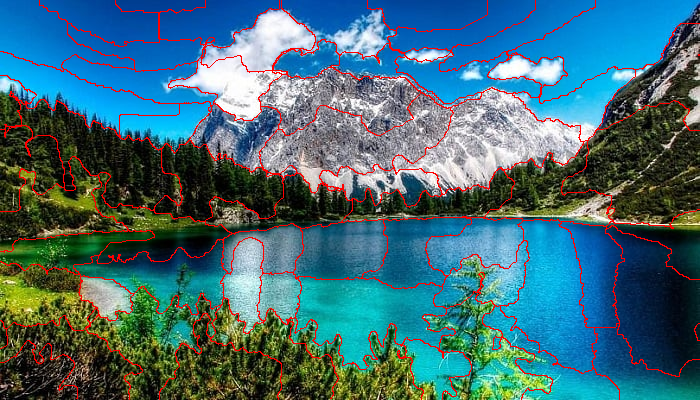

In [20]:
cv2_imshow(resultseeds)

Simple Linear Iterative Clustering

Initialize a SuperpixelSLIC object.

Parameters
* image	Image to segment
* algorithm	Chooses the algorithm variant to use: SLIC segments image using a desired region_size, and in addition SLICO will optimize using adaptive compactness factor, while MSLIC will optimize using manifold methods resulting in more content-sensitive superpixels.
* region_size	Chooses an average superpixel size measured in pixels
* ruler	Chooses the enforcement of superpixel smoothness factor of superpixel

The function initializes a SuperpixelSLIC object for the input image. It sets the parameters of choosed superpixel algorithm, which are: region_size and ruler. It preallocate some buffers for future computing iterations over the given image. For enanched results it is recommended for color images to preprocess image with little gaussian blur using a small 3 x 3 kernel and additional conversion into CieLAB color space. An example of SLIC versus SLICO and MSLIC is ilustrated in the following picture.



In [21]:
#img = input image, Algorithm (SLIC), REgion Size = S in Pixels, Ruler =enforcemet of superpixel smoothness (que tan cuadradiculado)
islic = cv2.ximgproc.createSuperpixelSLIC(img,	algorithm = cv2.ximgproc.MSLIC, region_size=25, ruler=128) 
islic.iterate(10) #Number of iterations, the bigger the better the effect

color_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
color_img[:] = (0, 0, 255)

mask_slic = islic.getLabelContourMask() #Get Mask, superpixel edge Mask==1
label_slic = islic.getLabels() #Get superpixel label
number_slic = islic.getNumberOfSuperpixels() #Get the number of superpixels
mask_inv_slic = cv2. bitwise_not(mask_slic)  
img_slic = cv2.bitwise_and(img,img,mask = mask_inv_slic) #Draw superpixel boundaries on the original image

img2 = cv2.bitwise_and(color_img, color_img, mask=mask_slic) 
resultslic = cv2.add(img_slic, img2)

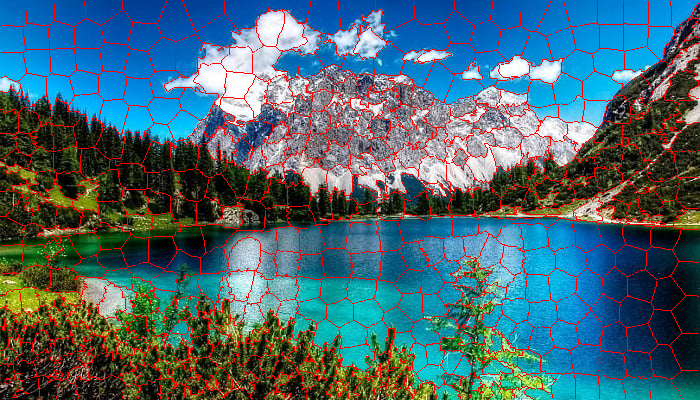

610


In [22]:
cv2_imshow(resultslic)
print(number_slic)

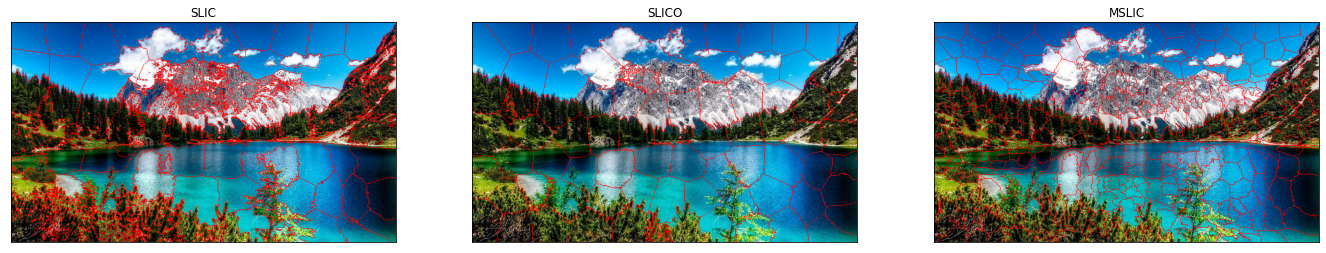

In [23]:
img = cv2.imread("sample_data/image.jpg")
titles = ['SLIC', 'SLICO','MSLIC']
SlicAlgorthm=[cv2.ximgproc.SLIC,cv2.ximgproc.SLICO,cv2.ximgproc.MSLIC]
SlicImages=[]


color_img = np.zeros((img.shape[0], img.shape[1],3), np.uint8)
color_img[:] = (0, 0, 255)

images = []

i=0
for i in range(3):
  islic = cv2.ximgproc.createSuperpixelSLIC(img,	algorithm = SlicAlgorthm[i],region_size=60,ruler=100.0)
  islic.iterate(10) #Number of iterations, the bigger the better the effect
  mask_slic = islic.getLabelContourMask() #Get Mask, superpixel edge Mask==1
  label_slic = islic.getLabels() #Get superpixel labels
  number_slic = islic.getNumberOfSuperpixels() #Get the number of superpixels
  mask_inv_slic = cv2. bitwise_not(mask_slic)  
  img_slic = cv2.bitwise_and(img,img,mask = mask_inv_slic) #Draw superpixel boundaries on the original image
  img2 = cv2.bitwise_and(color_img, color_img, mask=mask_slic) 
  resultslic = cv2.add(img_slic, img2)


  SlicImages.append(resultslic)


#original plot size was too small, following code is to have a bigger image
f = plt.figure(figsize=(16, 8))
f.set_figwidth(40)
f.set_figheight(30)
i=0

for i in range(3):
    SlicImages[i] = cv2.cvtColor(SlicImages[i], cv2.COLOR_BGR2RGB)    
    plt.subplot(2 ,5 , i+1),plt.imshow(SlicImages[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

Ejercicio con una imagen de color solido

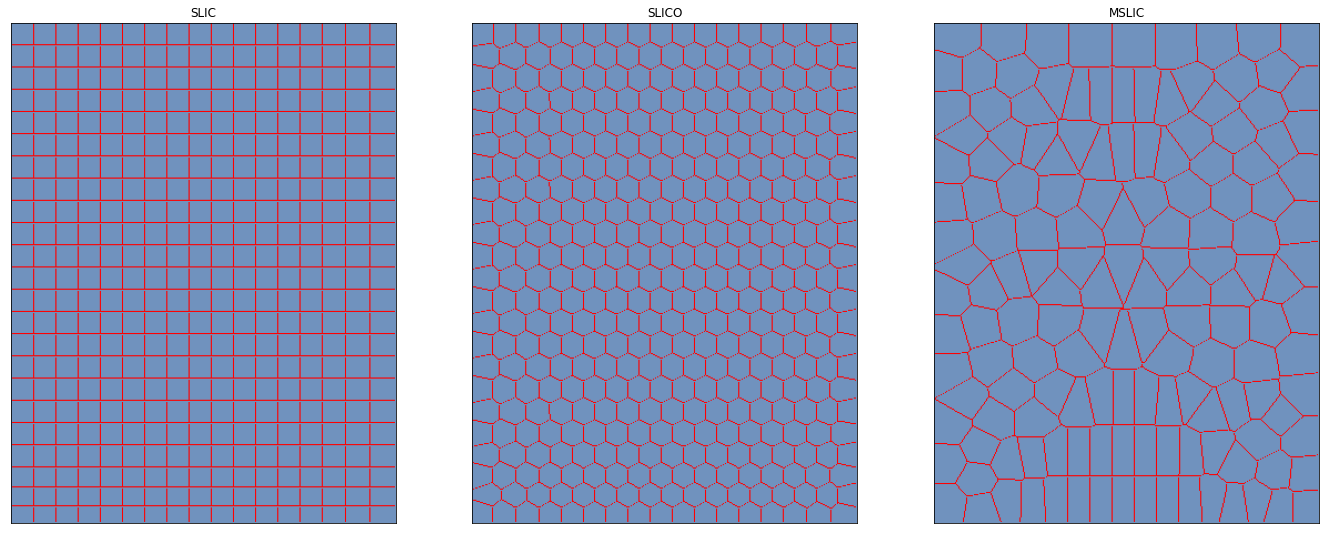

In [24]:
img = cv2.imread("sample_data/solid.png")
titles = ['SLIC', 'SLICO','MSLIC']
SlicAlgorthm=[cv2.ximgproc.SLIC,cv2.ximgproc.SLICO,cv2.ximgproc.MSLIC]
SlicImages=[]


color_img = np.zeros((img.shape[0], img.shape[1],3), np.uint8)
color_img[:] = (0, 0, 255)

i=0
for i in range(3):
  islic = cv2.ximgproc.createSuperpixelSLIC(img,	algorithm = SlicAlgorthm[i],region_size=20,ruler=1)
  islic.iterate(10) #Number of iterations, the bigger the better the effect
  mask_slic = islic.getLabelContourMask() #Get Mask, superpixel edge Mask==1
  label_slic = islic.getLabels() #Get superpixel labels
  number_slic = islic.getNumberOfSuperpixels() #Get the number of superpixels
  mask_inv_slic = cv2. bitwise_not(mask_slic)  
  img_slic = cv2.bitwise_and(img,img,mask = mask_inv_slic) #Draw superpixel boundaries on the original image
  img2 = cv2.bitwise_and(color_img, color_img, mask=mask_slic) 
  resultslic = cv2.add(img_slic, img2)


  SlicImages.append(resultslic)


#original plot size was too small, following code is to have a bigger image
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(30)
i=0

for i in range(3):
    SlicImages[i] = cv2.cvtColor(SlicImages[i], cv2.COLOR_BGR2RGB)    
    plt.subplot(2,5,i+1),plt.imshow(SlicImages[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

##Bibliografia
* OpenCV Documentation: https://docs.opencv.org/3.4/df/d6c/group__ximgproc__superpixel.html
*  Adrian Rosebrock,Segmentation: A SLIC Superpixel Tutorial using Python. July 28, 2014  https://pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/
* DiTect  Python - Opencv implements image superpixel segmentation (SLIC, SEEDS, LSC) https://www.zditect.com/code/python--opencv-implements-image-superpixel-segmentation-slic-seeds-lsc.html
* Manifold SLIC: A Fast Method to Compute Content-Sensitive Superpixels. Yong-Jin Liu, Cheng-Chi Yu, Min-Jing Yu.
Tsinghua University. Chinahttps://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_Manifold_SLIC_A_CVPR_2016_paper.pdf
* SLIC Superpixels Compared to State-of-the-art Superpixel Methods. Radhakrishna Achanta, Appu Shaji, Kevin Smith, Aurelien Lucchi, Pascal Fua, and Sabine Susstrunk. https://infoscience.epfl.ch/record/177415 
* SLIC Superpixels. https://www.epfl.ch/labs/ivrl/research/slic-superpixels/ 
* Image segmentation based on Superpixels and Clustering, Lampros Mouselimis. https://cran.r-project.org/web/packages/OpenImageR/vignettes/Image_segmentation_superpixels_clustering.html  